## Section 0: Import Libraries

In [1]:
# ============================================
# Core Libraries
# ============================================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import stats

# ============================================
# Environment
# ============================================
from dotenv import load_dotenv
load_dotenv()

# ============================================
# Database
# ============================================
import psycopg2
from psycopg2 import extras

# ============================================
# Sklearn - Model Selection
# ============================================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold
)

# ============================================
# Sklearn - Models
# ============================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# ============================================
# Sklearn - Metrics
# ============================================
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# ============================================
# Sklearn - Preprocessing
# ============================================
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ============================================
# Imbalanced-learn
# ============================================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# ============================================
# Visualization
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully!")

All libraries imported successfully!


## Section 1: Data Loading

Load data from PostgreSQL or CSV file.

In [2]:
def fetch_data_from_postgres(config):
    """
    Connects to PostgreSQL and retrieves enriched customer churn data
    by joining Dimension and Fact tables.
    
    Parameters:
    -----------
    config : dict
        Database configuration with keys: host, database, user, password
    
    Returns:
    --------
    pd.DataFrame : Training dataset with features and target variable
    """
    conn = None
    try:
        conn = psycopg2.connect(
            host=config['host'],
            database=config['database'],
            user=config['user'],
            password=config['password'],
            port=55432
        )
        print(f"Connected to database '{config['database']}'")
        
        # Complex SQL Query with CTE and Joins
        sql_query = """
        /* Step 1: CTE to aggregate sales behavior from detailed lines */
        WITH Aggregated_Sales AS (
            SELECT 
                fsol.customer_sk,
                COUNT(DISTINCT fsol.salesorder_id) AS total_lifetime_orders,
                -- Handle casting and NULLs for text-based DiscountPct
                COUNT(CASE WHEN NULLIF(dso."DiscountPct", '')::numeric > 0 THEN 1 END) AS count_discounted_items,
                MAX(dp.category_name) AS most_frequent_category_proxy,
                AVG(fsol.unit_price) AS avg_item_price
            FROM gold.fact_sales_order_line fsol
            -- Handle Case Sensitivity for SpecialOfferID
            LEFT JOIN gold.dim_specialoffer dso ON fsol.specialoffer_id = dso."SpecialOfferID"
            LEFT JOIN gold.dim_product dp ON fsol.product_sk = dp.product_sk
            GROUP BY fsol.customer_sk
        )

        /* Step 2: Main Select to join Churn Fact with Dimensions and Aggregated Sales */
        SELECT 
            -- 1. Target & IDs
            fcc.customer_sk,
            fcc.is_churned,

            -- 2. Behavioral Features (From Fact Churn)
            fcc.recency,
            fcc.frequency,
            fcc.monetary,
            fcc.avg_order_value,
            fcc.distinct_product_count,
            -- Excluded: complaint_cancel_ratio, backorder_ratio, potential_loss_value

            -- 3. Demographic Features (From Dim Customer)
            dc.territory_group,
            
            -- 4. Geographic & Regional Economic Features (From Dim Territory)
            dt.territory_name,
            dt.country_region_code,
            dt.sales_ytd AS territory_sales_ytd,
            
            -- 5. Address Features (From Dim Address)
            da.city,
            da.state_province_id,

            -- 6. Calculated Sales Features (From CTE - Handle NULLs with COALESCE)
            COALESCE(sa.total_lifetime_orders, 0) as total_lifetime_orders,
            COALESCE(sa.count_discounted_items, 0) as count_discounted_items,
            sa.avg_item_price,
            sa.most_frequent_category_proxy

        FROM gold.fact_customer_churn fcc
        -- Join Customer Dimension
        LEFT JOIN gold.dim_customer dc ON fcc.customer_sk = dc.customer_sk
        -- Join Territory Dimension
        LEFT JOIN gold.dim_territory dt ON fcc.territory_sk = dt.territory_sk
        -- Join Address Dimension
        LEFT JOIN gold.dim_address da ON fcc.address_sk = da.address_sk
        -- Join Aggregated Sales CTE
        LEFT JOIN Aggregated_Sales sa ON fcc.customer_sk = sa.customer_sk
        
        -- Ensure core data is not NULL
        WHERE fcc.recency IS NOT NULL 
          AND fcc.frequency IS NOT NULL
          AND fcc.is_churned IS NOT NULL;
        """
        
        df = pd.read_sql(sql_query, conn)
        print(f"Loaded {len(df)} records with enriched features.")
        return df
        
    except psycopg2.Error as e:
        print(f"✗ Database error: {e}")
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()
            print("Database connection closed")

In [3]:
# Option 1: Load from PostgreSQL
# Uncomment and configure if using PostgreSQL

db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'companyxdb'),
    'user': os.getenv('DB_USER', 'companyx'),
    'password': os.getenv('DB_PASS', 'P@ssW0rd'),
    'table': 'gold.fact_customer_churn'
}
df = fetch_data_from_postgres(db_config)

# Option 2: Load from CSV (for testing)
# df = pd.read_csv("churn.csv")
# print(f"Loaded {len(df)} records from CSV")

# Display basic information
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())

print(f"\nColumn data types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

Connected to database 'companyxdb'
Loaded 19119 records with enriched features.
Database connection closed

DATA OVERVIEW
Shape: (19119, 17)

First 5 rows:


,customer_sk,is_churned,recency,frequency,monetary,avg_order_value,distinct_product_count,territory_group,territory_name,country_region_code,territory_sales_ytd,city,state_province_id,total_lifetime_orders,count_discounted_items,avg_item_price,most_frequent_category_proxy
0,00053f5e11d1fe4e49a221165b39abc9,0,104,1,588.96,588.96,4,North America,Southwest,US,10510853.8739,Paris,161.0,1,0,147.240000,Bikes
1,0006aabe0ba47a35c0b0bf6596f85159,0,56,1,2354.98,2354.98,2,North America,Northwest,US,7887186.7882,La Jolla,9.0,1,0,1177.490000,Bikes
2,0006dd05ea1e999ddaa041a7091b7b36,1,193,1,1264.84,1264.84,2,Europe,France,FR,4772398.3078,Lebanon,58.0,1,0,632.420000,Clothing
3,000e82a96e908e73372bed4e5cb98096,0,88,2,4715.02,2357.51,5,Europe,United Kingdom,GB,5012905.3656,Leeds,14.0,3,0,1131.073267,Bikes
4,00126b47d5502dfb7d01f750ad23d813,1,227,1,54.98,54.98,2,North America,Northwest,US,7887186.7882,Drancy,179.0,1,0,27.490000,Clothing



Column data types:
customer_sk                      object
is_churned                        int64
recency                           int64
frequency                         int64
monetary                        float64
avg_order_value                 float64
distinct_product_count            int64
territory_group                  object
territory_name                   object
country_region_code              object
territory_sales_ytd              object
city                             object
state_province_id               float64
total_lifetime_orders             int64
count_discounted_items            int64
avg_item_price                  float64
most_frequent_category_proxy     object
dtype: object

Missing values:
customer_sk                        0
is_churned                         0
recency                            0
frequency                          0
monetary                           0
avg_order_value                 1039
distinct_product_count             0
territory_

## Section 2: Advanced Data Cleaning

Comprehensive data cleaning with outlier detection and handling.

In [4]:
def advanced_data_cleaning(df):
    """
    Comprehensive data cleaning pipeline for Churn Prediction.
    
    Improvements:
    - Explicitly treats 'state_province_id' as categorical.
    - Robust handling of mixed types in numeric columns.
    """
    print("\n" + "="*80)
    print("STEP 1: ADVANCED DATA CLEANING (IMPROVED)")
    print("="*80)
    
    df_clean = df.copy()
    initial_rows = len(df_clean)
    
    # 1. Handle ID Column
    if 'customer_sk' in df_clean.columns:
        df_clean.set_index('customer_sk', inplace=True)
        print("Set 'customer_sk' as dataframe index")

    # 2. Specific Type Conversion
    # Critical: 'territory_sales_ytd' comes as string/object in CSV, needs explicit conversion
    numeric_text_cols = ['territory_sales_ytd', 'territory_cost_ytd']
    for col in numeric_text_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            print(f"Converted '{col}' from Object to Numeric")

    # 3. Explicitly force ID-like columns to Categorical (String)
    # This prevents them from being treated as numbers (e.g., calculating median of IDs is wrong)
    id_cols = ['state_province_id']
    for col in id_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).replace('nan', np.nan)
            print(f"Forced '{col}' to behave as Categorical")

    # 4. Drop date columns
    if 'snapshot_date' in df_clean.columns:
        df_clean.drop(columns=['snapshot_date'], inplace=True)

    # 5. Auto-detect Feature Types
    target_col = 'is_churned'
    
    # Select numeric columns (exclude target)
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols: 
        numeric_cols.remove(target_col)
    
    # Select categorical columns (include object, category)
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Features detected: {len(numeric_cols)} Numeric, {len(categorical_cols)} Categorical")

    # 6. Handle Missing Values
    print("\nMissing Value Handling:")
    
    # 6a. Numeric: Impute with Median
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"   - (Numeric) {col}: Filled missing with Median ({median_val:.2f})")

    # 6b. Categorical: Impute with 'Unknown'
    for col in categorical_cols:
        if df_clean[col].isnull().any() or (df_clean[col] == 'nan').any():
            fill_val = 'Unknown'
            # Fill NaN
            df_clean[col] = df_clean[col].fillna(fill_val)
            # Replace string 'nan' if conversion left artifacts
            df_clean[col] = df_clean[col].replace('nan', fill_val)
            print(f"   - (Categorical) {col}: Filled missing with '{fill_val}'")

    # 7. Handle Infinite Values
    df_clean[numeric_cols] = df_clean[numeric_cols].replace([np.inf, -np.inf], np.nan)
    df_clean.dropna(subset=numeric_cols, inplace=True)

    # 8. Outlier Detection & Capping (IQR Method)
    # We skip columns with low cardinality (like counts) to avoid over-clipping
    skip_capping_cols = ['frequency', 'count_discounted_items', 'total_lifetime_orders', 'distinct_product_count']
    
    outlier_total = 0
    print("\nOutlier Capping:")
    for col in numeric_cols:
        if df_clean[col].nunique() <= 5 or col in skip_capping_cols:
            continue
            
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 3 * IQR # Using 3*IQR for extreme outliers only
        upper_bound = Q3 + 3 * IQR
        
        # Clip values
        original_sum = df_clean[col].sum()
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
        
        if df_clean[col].sum() != original_sum:
            outlier_total += 1
            print(f"   - Capped outliers in '{col}'")

    # 9. Sanity Check (No negative monetary values)
    if 'avg_order_value' in df_clean.columns:
        df_clean['avg_order_value'] = df_clean['avg_order_value'].clip(lower=0)

    # 10. Remove Duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"\nRemoved {duplicates} duplicate rows")

    cleaning_stats = {
        'initial_rows': initial_rows,
        'final_rows': len(df_clean),
        'rows_removed': initial_rows - len(df_clean)
    }
    
    return df_clean, cleaning_stats

In [5]:
# Execute data cleaning
df_clean, cleaning_stats = advanced_data_cleaning(df)

# Display cleaned data
print("\n" + "="*80)
print("CLEANED DATA SUMMARY")
print("="*80)
print(df_clean.describe())


STEP 1: ADVANCED DATA CLEANING (IMPROVED)
Set 'customer_sk' as dataframe index
Converted 'territory_sales_ytd' from Object to Numeric
Forced 'state_province_id' to behave as Categorical
Features detected: 9 Numeric, 6 Categorical

Missing Value Handling:
   - (Numeric) avg_order_value: Filled missing with Median (128.95)
   - (Categorical) city: Filled missing with 'Unknown'
   - (Categorical) state_province_id: Filled missing with 'Unknown'

Outlier Capping:
   - Capped outliers in 'recency'
   - Capped outliers in 'monetary'
   - Capped outliers in 'avg_order_value'
   - Capped outliers in 'avg_item_price'

Removed 41 duplicate rows

CLEANED DATA SUMMARY
         is_churned       recency     frequency      monetary  \
count  19078.000000  19078.000000  19078.000000  19078.000000   
mean       0.419226    186.559283      1.225967    952.875328   
std        0.493445    135.429301      1.100183   1394.571669   
min        0.000000      0.000000      0.000000      0.000000   
25%      

## Section 3: Train-Test Split and Data Preparation

In [6]:
print("="*80)
print("STEP 2: DATA PREPARATION & ENCODING")
print("="*80)

# Create a copy to avoid SettingWithCopy warnings
df_model = df_clean.copy()

# ---------------------------------------------------------
# 1. HANDLE CATEGORICAL VARIABLES (ENCODING & SAVING)
# ---------------------------------------------------------
# Identify categorical columns (object/string types)
# We exclude 'customer_sk' if it's still a column (it should be an index)
cat_cols = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
if 'customer_sk' in cat_cols:
    cat_cols.remove('customer_sk')

print(f"Encoding categorical columns: {cat_cols}")

# Initialize a dictionary to store encoders (CRITICAL for Section 12 predictions)
encoders = {}

for col in cat_cols:
    # Convert to string to ensure consistency before encoding
    df_model[col] = df_model[col].astype(str)
    
    # Initialize LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the data
    df_model[col] = le.fit_transform(df_model[col])
    
    # Save the encoder for later use
    encoders[col] = le

print("Categorical encoding complete. Encoders saved for inference.")

# ---------------------------------------------------------
# 2. FEATURE SELECTION & TARGET DEFINITION
# ---------------------------------------------------------
# Define Target (y)
y = df_model['is_churned'].astype(int)

# Define Features (X)
# CRITICAL: Drop 'is_churned' (Target) and 'recency' (Data Leakage)
# 'recency' is dropped because it is often used to *define* churn rules.
cols_to_drop = ['is_churned', 'recency']

# If customer_sk is still a column, drop it (it's an ID, not a feature)
if 'customer_sk' in df_model.columns:
    cols_to_drop.append('customer_sk')

X = df_model.drop(cols_to_drop, axis=1)

feature_names = X.columns.tolist()

# ---------------------------------------------------------
# 3. DATASET STATISTICS
# ---------------------------------------------------------
print(f"\nTotal samples: {len(X)}")
print(f"Total features: {len(feature_names)}")

# Calculate class distribution
num_non_churn = (y == 0).sum()
num_churn = (y == 1).sum()

print(f"\nClass distribution:")
print(f"  Non-Churn (0): {num_non_churn} ({num_non_churn / len(y) * 100:.2f}%)")
print(f"  Churn (1):     {num_churn} ({num_churn / len(y) * 100:.2f}%)")

# ---------------------------------------------------------
# 4. TRAIN-TEST SPLIT
# ---------------------------------------------------------
# Split data: 70% Training, 30% Testing
# 'stratify=y' ensures the Churn Rate is the same in both Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain-test split complete:")
print(f"   - Train set: {X_train.shape} samples | Churn Rate: {y_train.mean():.2%}")
print(f"   - Test set:  {X_test.shape} samples | Churn Rate: {y_test.mean():.2%}")

STEP 2: DATA PREPARATION & ENCODING
Encoding categorical columns: ['territory_group', 'territory_name', 'country_region_code', 'city', 'state_province_id', 'most_frequent_category_proxy']
Categorical encoding complete. Encoders saved for inference.

Total samples: 19078
Total features: 14

Class distribution:
  Non-Churn (0): 11080 (58.08%)
  Churn (1):     7998 (41.92%)

Train-test split complete:
   - Train set: (13354, 14) samples | Churn Rate: 41.92%
   - Test set:  (5724, 14) samples | Churn Rate: 41.93%


## Section 4: Handle Class Imbalance

Use SMOTE and hybrid sampling to balance the classes.

In [ ]:
# def handle_imbalance(X_train, y_train, method='hybrid'):
#     """
#     Handle imbalanced classes using SMOTE or hybrid approach.
#     """
#     print("\n" + "="*80)
#     print(f"HANDLING CLASS IMBALANCE - Method: {method.upper()}")
#     print("="*80)
#     print(f"Original distribution: Non-Churn={np.sum(y_train==0)}, Churn={np.sum(y_train==1)}")
    
#     if method == 'smote':
#         sampler = SMOTE(random_state=42, k_neighbors=3)
#     elif method == 'undersample':
#         sampler = RandomUnderSampler(random_state=42)
#     elif method == 'hybrid':
#         # First undersample majority, then oversample minority
#         sampler = ImbPipeline([
#             ('undersample', RandomUnderSampler(sampling_strategy="auto", random_state=42)),
#             ('oversample', SMOTE(random_state=42, k_neighbors=3))
#         ])
    
#     X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
#     print(f"Resampled distribution: Non-Churn={np.sum(y_resampled==0)}, Churn={np.sum(y_resampled==1)}")
#     print(f"Balanced dataset: {len(X_resampled)} total samples")
    
#     return X_resampled, y_resampled

In [7]:
# Handle imbalance
# X_train_balanced, y_train_balanced = handle_imbalance(X_train, y_train, method='hybrid')
X_train_balanced, y_train_balanced = X_train, y_train

## Section 5: Feature Scaling

In [8]:
# ==============================================================================
# SECTION 5: FEATURE SCALING
# ==============================================================================


# Scale features using StandardScaler
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

# Initialize Scaler
scaler = StandardScaler()

# Fit on Training data only, then transform both Train and Test
# This prevents "Data Leakage" from the test set into the training process
X_train_scaled = scaler.fit_transform(X_train_balanced) # Assuming you ran Section 4 (Balancing)
X_test_scaled = scaler.transform(X_test)

# If you skipped Section 4 (Balancing), use X_train instead:
# X_train_scaled = scaler.fit_transform(X_train) 

print("Features scaled using StandardScaler")
print(f"   - Train shape: {X_train_scaled.shape}")
print(f"   - Test shape:  {X_test_scaled.shape}")

print(f"\nSample statistics after scaling (first 3 features):")
for i in range(min(3, X_train_scaled.shape[1])):
    print(f"   Feature {i} ({feature_names[i]}): mean={X_train_scaled[:, i].mean():.4f}, std={X_train_scaled[:, i].std():.4f}")


FEATURE SCALING
Features scaled using StandardScaler
   - Train shape: (13354, 14)
   - Test shape:  (5724, 14)

Sample statistics after scaling (first 3 features):
   Feature 0 (frequency): mean=0.0000, std=1.0000
   Feature 1 (monetary): mean=0.0000, std=1.0000
   Feature 2 (avg_order_value): mean=0.0000, std=1.0000


## Section 6: Train Multiple Models

Train Random Forest, Gradient Boosting, and Logistic Regression.

In [9]:
# Define models with optimized hyperparameters to reduce overfitting
print("\n" + "="*80)
print("MODEL TRAINING (TUNED HYPERPARAMETERS)")
print("="*80)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=1000,
        max_depth=10,          # Reduced from 15 to 10 to limit complexity
        min_samples_split=40,  # Increased from 20 to 40
        min_samples_leaf=20,   # Increased from 10 to 20 for smoother boundaries
        max_features='sqrt',
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,      # Slightly reduced from 200
        max_depth=4,           # CRITICAL: Reduced from 10 to 4 to fix significant overfitting
        learning_rate=0.05,
        min_samples_split=40,  # Increased regularization
        min_samples_leaf=20,   # Increased regularization
        subsample=0.8,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        C=0.1,                 # Added stronger regularization (default is 1.0)
        class_weight='balanced',
        random_state=42,
        solver='lbfgs'
    )
}

print(f"Initialized {len(models)} models with tuned parameters.")
for name in models.keys():
    print(f"   - {name}")


MODEL TRAINING (TUNED HYPERPARAMETERS)
Initialized 3 models with tuned parameters.
   - Random Forest
   - Gradient Boosting
   - Logistic Regression


In [10]:
# Train models and perform cross-validation
results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    # Cross-validation
    print("Performing 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train_balanced, 
                                cv=cv, scoring='roc_auc', n_jobs=-1)
    
    print(f"   CV AUC Scores: {cv_scores}")
    print(f"   CV AUC Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # Train model
    print("Training model on full training set...")
    model.fit(X_train_scaled, y_train_balanced)
    print("Training complete")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    print("Predictions on test set complete", y_pred)
    
    # Calculate metrics
    results[name] = {
        'model': model,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_pred_proba),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\nTest Set Performance:")
    print(f"   - Accuracy:  {results[name]['test_accuracy']:.4f}")
    print(f"   - Precision: {results[name]['test_precision']:.4f}")
    print(f"   - Recall:    {results[name]['test_recall']:.4f}")
    print(f"   - F1 Score:  {results[name]['test_f1']:.4f}")
    print(f"   - AUC:       {results[name]['test_auc']:.4f}")

print(f"\n{'='*80}")
print("ALL MODELS TRAINED SUCCESSFULLY")
print(f"{'='*80}")


Training: Random Forest
Performing 5-fold cross-validation...
   CV AUC Scores: [0.84506424 0.85243075 0.86286929 0.8368544  0.84833619]
   CV AUC Mean: 0.8491 (+/- 0.0086)
Training model on full training set...
Training complete
Predictions on test set complete [0 0 1 ... 1 1 0]

Test Set Performance:
   - Accuracy:  0.7897
   - Precision: 0.6950
   - Recall:    0.8879
   - F1 Score:  0.7797
   - AUC:       0.8520

Training: Gradient Boosting
Performing 5-fold cross-validation...
   CV AUC Scores: [0.85217314 0.85612048 0.86694845 0.84385163 0.85180941]
   CV AUC Mean: 0.8542 (+/- 0.0075)
Training model on full training set...
Training complete
Predictions on test set complete [0 0 0 ... 1 1 0]

Test Set Performance:
   - Accuracy:  0.7935
   - Precision: 0.7099
   - Recall:    0.8583
   - F1 Score:  0.7771
   - AUC:       0.8552

Training: Logistic Regression
Performing 5-fold cross-validation...
   CV AUC Scores: [0.83370061 0.82881119 0.83016228 0.81771798 0.82680262]
   CV AUC Me

## Section 7: Model Comparison and Selection

In [11]:
# Create comparison dataframe
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV AUC': [f"{r['cv_auc_mean']:.4f} ± {r['cv_auc_std']:.4f}" for r in results.values()],
    'Test Accuracy': [f"{r['test_accuracy']:.4f}" for r in results.values()],
    'Test Precision': [f"{r['test_precision']:.4f}" for r in results.values()],
    'Test Recall': [f"{r['test_recall']:.4f}" for r in results.values()],
    'Test F1': [f"{r['test_f1']:.4f}" for r in results.values()],
    'Test AUC': [f"{r['test_auc']:.4f}" for r in results.values()]
})

display(comparison_df)

# Select best model based on AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['test_auc'])
best_model_results = results[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"Test AUC Score: {best_model_results['test_auc']:.4f}")


MODEL PERFORMANCE COMPARISON


,Model,CV AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test AUC
0,Random Forest,0.8491 ± 0.0086,0.7897,0.6950,0.8879,0.7797,0.8520
1,Gradient Boosting,0.8542 ± 0.0075,0.7935,0.7099,0.8583,0.7771,0.8552
2,Logistic Regression,0.8274 ± 0.0054,0.7458,0.6519,0.8450,0.7360,0.8261



BEST MODEL: Gradient Boosting
Test AUC Score: 0.8552


## Section 8: Detailed Evaluation - Best Model

In [12]:
# Detailed classification report
print("\n" + "="*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*80)

print(classification_report(
    y_test, 
    best_model_results['predictions'],
    target_names=['Non-Churn (0)', 'Churn (1)'],
    digits=4
))

# Confusion Matrix
print("\nCONFUSION MATRIX:")
cm = confusion_matrix(y_test, best_model_results['predictions'])
print(f"\n                 Predicted")
print(f"                 Non-Churn  Churn")
print(f"Actual Non-Churn    {cm[0][0]:5d}    {cm[0][1]:5d}")
print(f"       Churn        {cm[1][0]:5d}    {cm[1][1]:5d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"\nADDITIONAL METRICS:")
print(f"   - Specificity (TNR):          {specificity:.4f}")
print(f"   - Negative Predictive Value:  {npv:.4f}")
print(f"   - False Positive Rate:        {fpr:.4f}")
print(f"   - False Negative Rate:        {fnr:.4f}")


DETAILED CLASSIFICATION REPORT - Gradient Boosting
               precision    recall  f1-score   support

Non-Churn (0)     0.8795    0.7467    0.8077      3324
    Churn (1)     0.7099    0.8583    0.7771      2400

     accuracy                         0.7935      5724
    macro avg     0.7947    0.8025    0.7924      5724
 weighted avg     0.8084    0.7935    0.7948      5724


CONFUSION MATRIX:

                 Predicted
                 Non-Churn  Churn
Actual Non-Churn     2482      842
       Churn          340     2060

ADDITIONAL METRICS:
   - Specificity (TNR):          0.7467
   - Negative Predictive Value:  0.8795
   - False Positive Rate:        0.2533
   - False Negative Rate:        0.1417


## Section 9: Feature Importance Analysis


FEATURE IMPORTANCE - Gradient Boosting

TOP 10 MOST IMPORTANT FEATURES:
    1. distinct_product_count              0.6562 █████████████████████████████████████████████████████████████████
    2. monetary                            0.1955 ███████████████████
    3. avg_item_price                      0.0520 █████
    4. frequency                           0.0261 ██
    5. avg_order_value                     0.0232 ██
    6. city                                0.0155 █
    7. total_lifetime_orders               0.0080 
    8. state_province_id                   0.0075 
    9. territory_name                      0.0045 
   10. territory_sales_ytd                 0.0039 


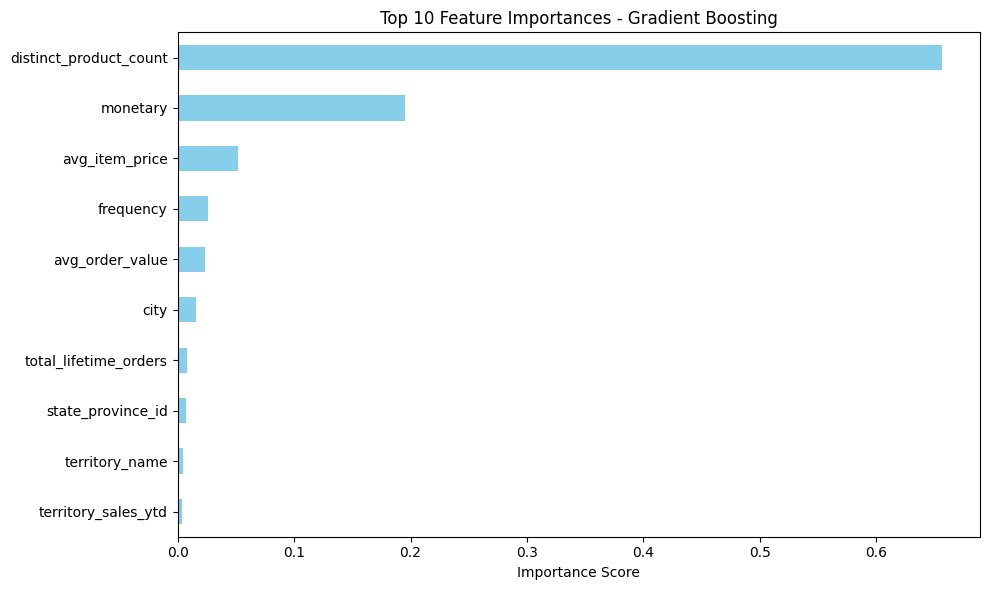

In [13]:
# Feature importance (for tree-based models)
if hasattr(best_model_results['model'], 'feature_importances_'):
    print("\n" + "="*80)
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print("="*80)
    
    importances = pd.Series(
        best_model_results['model'].feature_importances_,
        index=feature_names
    ).sort_values(ascending=False)
    
    print("\nTOP 10 MOST IMPORTANT FEATURES:")
    for i, (feat, imp) in enumerate(importances.head(10).items(), 1):
        print(f"   {i:2d}. {feat:35s} {imp:.4f} {'█' * int(imp * 100)}")
    
    # Visualize top 10 features
    plt.figure(figsize=(10, 6))
    importances.head(10).plot(kind='barh', color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} does not support feature importance analysis.")

## Section 10: Overfitting Analysis

In [14]:
print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)

for name, result in results.items():
    model = result['model']
    
    # Train set performance
    y_train_pred = model.predict(X_train_scaled)
    y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
    
    train_auc = roc_auc_score(y_train_balanced, y_train_proba)
    train_acc = accuracy_score(y_train_balanced, y_train_pred)
    train_f1 = f1_score(y_train_balanced, y_train_pred)
    
    # Test set performance
    test_auc = result['test_auc']
    test_acc = result['test_accuracy']
    test_f1 = result['test_f1']
    
    # Calculate gaps
    auc_gap = train_auc - test_auc
    acc_gap = train_acc - test_acc
    f1_gap = train_f1 - test_f1
    
    print(f"\n{name}:")
    print(f"   Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f} | Gap: {auc_gap:.4f}")
    print(f"   Train ACC: {train_acc:.4f} | Test ACC: {test_acc:.4f} | Gap: {acc_gap:.4f}")
    print(f"   Train F1:  {train_f1:.4f} | Test F1:  {test_f1:.4f} | Gap: {f1_gap:.4f}")
    
    # Overfitting assessment
    if auc_gap > 0.1:
        print(f"   Significant overfitting detected (AUC gap: {auc_gap:.4f})")
    elif auc_gap > 0.05:
        print(f"   Mild overfitting (AUC gap: {auc_gap:.4f})")
    else:
        print(f"   Good generalization (AUC gap: {auc_gap:.4f})")


OVERFITTING ANALYSIS

Random Forest:
   Train AUC: 0.8889 | Test AUC: 0.8520 | Gap: 0.0369
   Train ACC: 0.7916 | Test ACC: 0.7897 | Gap: 0.0019
   Train F1:  0.7812 | Test F1:  0.7797 | Gap: 0.0015
   Good generalization (AUC gap: 0.0369)

Gradient Boosting:
   Train AUC: 0.8843 | Test AUC: 0.8552 | Gap: 0.0291
   Train ACC: 0.8028 | Test ACC: 0.7935 | Gap: 0.0093
   Train F1:  0.7877 | Test F1:  0.7771 | Gap: 0.0106
   Good generalization (AUC gap: 0.0291)

Logistic Regression:
   Train AUC: 0.8290 | Test AUC: 0.8261 | Gap: 0.0028
   Train ACC: 0.7520 | Test ACC: 0.7458 | Gap: 0.0062
   Train F1:  0.7403 | Test F1:  0.7360 | Gap: 0.0043
   Good generalization (AUC gap: 0.0028)


## Section 11: ROC Curve Visualization

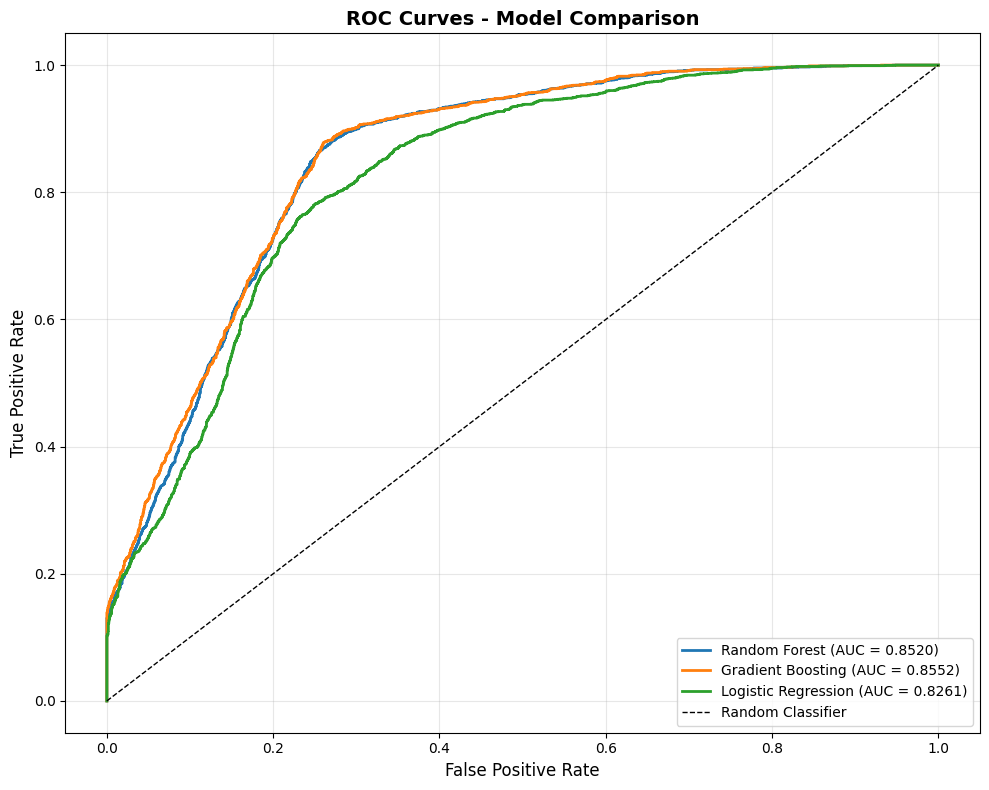

In [15]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = result['test_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Section 12: Predict on New Customers

In [16]:
# --- UPDATE FOR SECTION 12: PREDICT ON NEW CUSTOMERS ---

def predict_new_customers(model, scaler, encoders, feature_names, new_data_dict):
    """
    Make predictions on new customer data handling encoding and scaling.
    """
    print("\n" + "="*80)
    print("PREDICTING NEW CUSTOMERS")
    print("="*80)
    
    # 1. Convert dictionary to DataFrame
    new_df = pd.DataFrame(new_data_dict)
    
    # 2. Check for missing columns (The columns you added in Section 1)
    # We must fill missing categorical/numerical features with default/median values
    # purely for the code to run, but in reality, you should provide these values.
    expected_cols = feature_names # feature_names does NOT include 'recency' or 'is_churned'
    
    for col in expected_cols:
        if col not in new_df.columns:
            print(f"⚠ Warning: Missing column '{col}' in new data. Filling with default.")
            if col in encoders: # If categorical
                # Fill with the most frequent class (mode) from encoder classes if possible
                new_df[col] = encoders[col].classes_[0] 
            else: # If numerical
                new_df[col] = 0 # Or use a global median if available
    
    # 3. Apply Encoding (Reuse encoders from Section 3)
    # Handle 'unseen labels' (e.g., a City not in training set)
    for col, le in encoders.items():
        if col in new_df.columns:
            # Convert to string first
            new_df[col] = new_df[col].astype(str)
            
            # Map known labels, handle unknown
            # This is a safe way to handle new categories not seen in training
            new_df[col] = new_df[col].map(lambda s: s if s in le.classes_ else le.classes_[0])
            new_df[col] = le.transform(new_df[col])

    # 4. Select features in the exact order as X_train
    # Ensure we don't pass 'recency' if it was dropped in training
    X_new = new_df[expected_cols]
    
    # 5. Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # 6. Predict
    predictions = model.predict(X_new_scaled)
    probabilities = model.predict_proba(X_new_scaled)
    
    # 7. Create results
    results_df = pd.DataFrame({
        'Customer_ID': range(1, len(predictions) + 1),
        'Prediction': ['CHURN' if p == 1 else 'NON-CHURN' for p in predictions],
        'Churn_Probability': probabilities[:, 1].round(4),
        'Risk_Level': ['HIGH' if p > 0.7 else 'MEDIUM' if p > 0.4 else 'LOW' 
                       for p in probabilities[:, 1]]
    })
    
    print("\nPREDICTION RESULTS:")
    display(results_df)
    
    return results_df


In [17]:
# ==============================================================================
# SECTION 12: PREDICT ON NEW DATA (SCENARIO TESTING)
# ==============================================================================

# 1. Define new customer profiles for testing
# We simulate different customer behaviors to validate model logic
new_customers_data = [
    # Customer 1: VIP Profile (High frequency, high monetary value)
    # Expected: LOW Risk
    {
        "recency": 5, 
        "frequency": 50, 
        "monetary": 8000.0, 
        "avg_order_value": 160.0, 
        "distinct_product_count": 60,
        "total_lifetime_orders": 50, 
        "count_discounted_items": 5,
        "territory_group": "North America", 
        "territory_name": "Southwest", 
        "country_region_code": "US",
        "city": "Paris", 
        "state_province_id": 161.0,
        "territory_sales_ytd": 10510853.87, 
        "avg_item_price": 150.0,
        "most_frequent_category_proxy": "Bikes"
    },
    
    # Customer 2: Dormant but Valuable (High Recency, Good History)
    # Expected: LOW Risk (Model ignores Recency to avoid leakage, focuses on value)
    {
        "recency": 400, 
        "frequency": 5, 
        "monetary": 1000.0,
        "avg_order_value": 200.0, 
        "distinct_product_count": 10,
        "total_lifetime_orders": 5, 
        "count_discounted_items": 0,
        "territory_group": "Europe", 
        "territory_name": "France", 
        "country_region_code": "FR",
        "city": "Unknown", 
        "state_province_id": 58.0,
        "territory_sales_ytd": 4772398.30, 
        "avg_item_price": 200.0,
        "most_frequent_category_proxy": "Clothing"
    },
    
    # Customer 3: High Risk (One-time buyer, very low value)
    # Expected: HIGH Risk (Matches Feature Importance analysis)
    {
        "recency": 20, 
        "frequency": 1, 
        "monetary": 25.0,
        "avg_order_value": 25.0, 
        "distinct_product_count": 1, 
        "total_lifetime_orders": 1, 
        "count_discounted_items": 0,
        "territory_group": "North America", 
        "territory_name": "Northwest", 
        "country_region_code": "US",
        "city": "Seattle", 
        "state_province_id": 11.0,
        "territory_sales_ytd": 7887186.79, 
        "avg_item_price": 25.0,
        "most_frequent_category_proxy": "Accessories"
    },
    
    # Customer 4: Medium Risk (Low frequency, low monetary)
    # Expected: MEDIUM/HIGH Risk
    {
        "recency": 60, 
        "frequency": 2, 
        "monetary": 45.0,
        "avg_order_value": 22.5, 
        "distinct_product_count": 2,
        "total_lifetime_orders": 2, 
        "count_discounted_items": 0,
        "territory_group": "Europe", 
        "territory_name": "Germany", 
        "country_region_code": "DE",
        "city": "Berlin", 
        "state_province_id": 20.0, 
        "territory_sales_ytd": 4000000.00, 
        "avg_item_price": 22.5,
        "most_frequent_category_proxy": "Clothing"
    }
]

# 2. Execute Prediction
# Using the best model found (Gradient Boosting)
predictions_df = predict_new_customers(
    best_model_results['model'],
    scaler,
    encoders, 
    feature_names, 
    new_customers_data
)


PREDICTING NEW CUSTOMERS

PREDICTION RESULTS:


,Customer_ID,Prediction,Churn_Probability,Risk_Level
0,1,NON-CHURN,0.0164,LOW
1,2,NON-CHURN,0.0232,LOW
2,3,CHURN,0.7448,HIGH
3,4,CHURN,0.5258,MEDIUM


## Section 13: Summary and Recommendations

In [18]:
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)

removal_rate = (cleaning_stats['rows_removed'] / cleaning_stats['initial_rows']) * 100

print(f"Data Cleaning:")
print(f"   - Initial records: {cleaning_stats['initial_rows']}")
print(f"   - Final records: {cleaning_stats['final_rows']}")
print(f"   - Removal rate: {removal_rate:.2f}%")

print(f"\nModels Trained: {len(models)}")
for name in models.keys():
    print(f"   - {name}")

if 'best_model_name' in locals():
    print(f"\nBest Model: {best_model_name}")
    print(f"   - Test AUC: {best_model_results['test_auc']:.4f}")
    if 'test_f1' in best_model_results:
        print(f"   - Test F1: {best_model_results['test_f1']:.4f}")
    if 'test_accuracy' in best_model_results:
        print(f"   - Test Accuracy: {best_model_results['test_accuracy']:.4f}")
else:
    print("\nBest Model: Not selected yet (Check Section 7)")

print("\nRECOMMENDATIONS:")
print("   1. Focus retention efforts on customers with Churn Probability > 0.7")
print("   2. Monitor top 3 feature importances closely for early intervention")
print("   3. Re-train model monthly with new data to maintain performance")
print("   4. Consider A/B testing retention strategies on MEDIUM risk customers")
print("   5. Integrate predictions into CRM for automated alerts")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


PROJECT SUMMARY
Data Cleaning:
   - Initial records: 19119
   - Final records: 19078
   - Removal rate: 0.21%

Models Trained: 3
   - Random Forest
   - Gradient Boosting
   - Logistic Regression

Best Model: Gradient Boosting
   - Test AUC: 0.8552
   - Test F1: 0.7771
   - Test Accuracy: 0.7935

RECOMMENDATIONS:
   1. Focus retention efforts on customers with Churn Probability > 0.7
   2. Monitor top 3 feature importances closely for early intervention
   3. Re-train model monthly with new data to maintain performance
   4. Consider A/B testing retention strategies on MEDIUM risk customers
   5. Integrate predictions into CRM for automated alerts

ANALYSIS COMPLETE


## Final: Store churn predictions in database

In [32]:
def store_churn_predictions(config, final_df, table_name="gold.fact_customer_churn"):
    conn = None
    try:
        conn = psycopg2.connect(
            host=config['host'],
            database=config['database'],
            user=config['user'],
            password=config['password'],
            port=55432
        )
        conn.autocommit = False
        cur = conn.cursor()
        print(f"✓ Connected to database. Preparing to update table '{table_name}'...")

        alter_query = f"""
            ALTER TABLE {table_name} 
            ADD COLUMN IF NOT EXISTS churn_prediction INT,
            ADD COLUMN IF NOT EXISTS churn_probability FLOAT;
        """
        cur.execute(alter_query)
        conn.commit()
        print("✓ Checked/Created columns 'churn_prediction' and 'churn_probability'.")

        df_update = final_df.copy()

        if df_update.index.name == 'customer_sk' or 'customer_sk' not in df_update.columns:
            df_update.reset_index(inplace=True)

        data_to_update = df_update[['customer_sk', 'predictions', 'churn_probability']]
        
        values_list = [tuple(x) for x in data_to_update.to_numpy()]

        sql_update = f"""
            UPDATE {table_name} AS t
            SET 
                churn_prediction = v.pred,
                churn_probability = v.prob
            FROM (VALUES %s) AS v(sk, pred, prob)
            WHERE t.customer_sk = v.sk
        """

        psycopg2.extras.execute_values(
            cur,
            sql_update,
            values_list,
            page_size=1000 
        )
        conn.commit()
        print(f"✓ Successfully UPDATED {len(values_list)} rows in '{table_name}'.")
        
        return True

    except psycopg2.Error as e:
        print(f"✗ Database error: {e}")
        if conn:
            conn.rollback()
        return False
        
    finally:
        if conn:
            cur.close()
            conn.close()
            print("Database connection closed")

In [33]:
model = best_model_results['model']

# Get new probabilites from best model for training data
train_result_predict = model.predict(X_train_scaled)
train_result_proba = model.predict_proba(X_train_scaled)[:, 1]

df_train_final = X_train_balanced.copy()


df_train_final['predictions'] = train_result_predict
df_train_final['churn_probability'] = train_result_proba

df_test_final = X_test.copy() 

df_test_final['predictions'] = best_model_results["predictions"]
df_test_final['churn_probability'] = best_model_results["probabilities"]


final_X = pd.concat([df_train_final, df_test_final], axis=0)

store_churn_predictions(db_config, final_X, table_name="gold.fact_customer_churn")

✓ Connected to database. Preparing to update table 'gold.fact_customer_churn'...
✓ Checked/Created columns 'churn_prediction' and 'churn_probability'.
✓ Successfully UPDATED 19078 rows in 'gold.fact_customer_churn'.
Database connection closed


True